meta: 0 - sem objetivo de mudar de emprego
meta: 1 - com objetivo de mudar de emprego

In [64]:
# Importar as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [65]:
tabela = pd.read_csv("aug_train.csv")
tabela_teste = pd.read_csv("aug_test.csv")


In [66]:
# Organizando o nome das colunas

nome_coluna = {
    'enrollee_id' : 'id', 
    'city': 'cidade', 
    'city_development_index': 'idh',
    'gender': 'genero',
    'relevent_experience': 'experiencia_relevante',
    'enrolled_university': 'tipo_curso', 
    'education_level': 'nivel_educacao',
    'major_discipline': 'disciplina_principal', 
    'experience': 'experiencia', 
    'company_size': 'tamanho_da_empresa', 
    'company_type': 'tipo_da_empresa',
    'last_new_job': 'tempo_ultimo_emprego', 
    'training_hours': 'tempo_treinamento', 
    'target': 'meta'
    }

nome_coluna_teste = {
    'enrollee_id' : 'id', 
    'city': 'cidade', 
    'city_development_index': 'idh',
    'gender': 'genero',
    'relevent_experience': 'experiencia_relevante',
    'enrolled_university': 'tipo_curso', 
    'education_level': 'nivel_educacao',
    'major_discipline': 'disciplina_principal', 
    'experience': 'experiencia', 
    'company_size': 'tamanho_da_empresa', 
    'company_type': 'tipo_da_empresa',
    'last_new_job': 'tempo_ultimo_emprego', 
    'training_hours': 'tempo_treinamento'
    }

tabela = tabela.rename(columns=nome_coluna)
tabela_teste = tabela_teste.rename(columns=nome_coluna_teste)

tabela_2 = tabela.copy()
tabela_teste_2 = tabela_teste.copy()

In [67]:
print(tabela_teste.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2129 non-null   int64  
 1   cidade                 2129 non-null   object 
 2   idh                    2129 non-null   float64
 3   genero                 1621 non-null   object 
 4   experiencia_relevante  2129 non-null   object 
 5   tipo_curso             2098 non-null   object 
 6   nivel_educacao         2077 non-null   object 
 7   disciplina_principal   1817 non-null   object 
 8   experiencia            2124 non-null   object 
 9   tamanho_da_empresa     1507 non-null   object 
 10  tipo_da_empresa        1495 non-null   object 
 11  tempo_ultimo_emprego   2089 non-null   object 
 12  tempo_treinamento      2129 non-null   int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 216.4+ KB
None


In [68]:
print(tabela.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     19158 non-null  int64  
 1   cidade                 19158 non-null  object 
 2   idh                    19158 non-null  float64
 3   genero                 14650 non-null  object 
 4   experiencia_relevante  19158 non-null  object 
 5   tipo_curso             18772 non-null  object 
 6   nivel_educacao         18698 non-null  object 
 7   disciplina_principal   16345 non-null  object 
 8   experiencia            19093 non-null  object 
 9   tamanho_da_empresa     13220 non-null  object 
 10  tipo_da_empresa        13018 non-null  object 
 11  tempo_ultimo_emprego   18735 non-null  object 
 12  tempo_treinamento      19158 non-null  int64  
 13  meta                   19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
memory usage: 2.0+

In [69]:
# # Alterando a meta numerica para alfabetica
tabela['meta'] = tabela['meta'].astype('object')

tabela.loc[tabela['experiencia'] == '>20', 'experiencia'] = 21
tabela.loc[tabela['experiencia'] == '<1', 'experiencia'] = 0.5
tabela['experiencia'] = tabela['experiencia'].astype(float)

tabela.loc[tabela['meta'] == 1, 'meta'] = 'Sim'
tabela.loc[tabela['meta'] == 0, 'meta'] = 'Não'

Função para as análises

In [70]:
def analise_colunas(tabela, colunas):
    tabela_filtrada = tabela[[colunas, 'meta']]
    tabela_deploy = pd.DataFrame(columns=[f'{colunas}', 'Total', 'Sim', 'Porc_sim', 'Não', 'Porc_não'])
    

    for valores in tabela_filtrada[colunas].drop_duplicates().dropna().values:
        nova_tabela = tabela_filtrada.loc[tabela_filtrada[colunas] == valores, :]
        qtd_sim = nova_tabela.loc[nova_tabela['meta'] == 'Sim', :].count().values[0]
        qtd_não = nova_tabela.loc[nova_tabela['meta'] == 'Não', :].count().values[0]
        deploy = {f'{colunas}': [valores],
                  'Total': [len(nova_tabela)],
                  'Sim': [qtd_sim],
                  'Porc_sim': [round(qtd_sim / len(nova_tabela)*100, 2)],
                  'Não': [qtd_não],
                  'Porc_não': [round(qtd_não / len(nova_tabela)*100, 2)]}
        tabela_deploy = pd.DataFrame(tabela_deploy).dropna(axis=1, how='all')
        tabela_deploy = pd.concat([tabela_deploy, pd.DataFrame(deploy)], ignore_index=True)

    pd.set_option('display.max_rows', None)
    display(tabela_deploy)

    # Gráfico de barras
    plt.figure(figsize=(10, 6))
    tabela_deploy['Porc_sim'] = tabela_deploy['Porc_sim'].astype(float)
    tabela_deploy['Porc_não'] = tabela_deploy['Porc_não'].astype(float)

    tabela_deploy_melted = tabela_deploy.melt(id_vars=[colunas], value_vars=['Porc_sim', 'Porc_não'], 
                                             var_name='Resposta', value_name='Porcentagem')

    ax = sns.barplot(data=tabela_deploy_melted, x=colunas, y='Porcentagem', hue='Resposta')
    plt.title(f'Análise de {colunas}')
    plt.xlabel(colunas)
    plt.ylabel('Porcentagem (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 115)
    plt.legend(title='Meta', loc='upper right')

    # Identificar os dois maiores valores por segmento
    top_values = tabela_deploy_melted.groupby('Resposta')['Porcentagem'].nlargest(1).reset_index()
    top_indices = top_values['level_1'].values

    # Adicionando rótulos de dados e destacando os dois maiores valores por segmento
    for i, p in enumerate(ax.patches):
        value = p.get_height()
        color = 'red' if i in top_indices else 'black'
        ax.annotate(f'{value:.2f}%', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='baseline', fontsize=10, color=color, xytext=(0, 5),
                    textcoords='offset points')
    
    plt.tight_layout()
    plt.show()

Análise idh 

,idh,Total,Sim,Porc_sim,Não,Porc_não
0,baixo (menor que 0.550),425.0,250.0,58.82,175.0,41.18
1,médio (entre 0.550 e 0.699),4131.0,2074.0,50.21,2057.0,49.79
2,alto (entre 0.700 e 0.799),1410.0,348.0,24.68,1062.0,75.32
3,muito alto(0.800 ou maior),13192.0,2105.0,15.96,11087.0,84.04


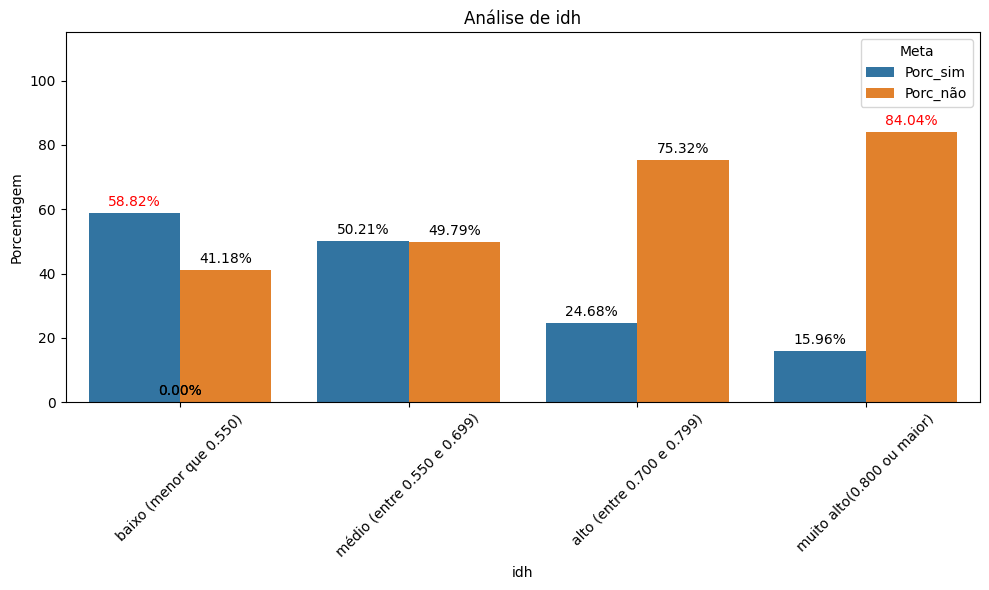

In [71]:
# Definindo os bins (intervalos) e as respectivas categorias
bins = [0, 0.550, 0.700, 0.800, 1]
labels = ['baixo (menor que 0.550)', 'médio (entre 0.550 e 0.699)', 'alto (entre 0.700 e 0.799)', 'muito alto(0.800 ou maior)']

# Criando uma nova coluna categorizada
tabela['idh'] = pd.cut(tabela['idh'], bins=bins, labels=labels)


# Função para agrupar as colunas e calcular contagens e porcentagens
resultado = (tabela.groupby('idh',observed=True ).apply(lambda x: pd.Series({
            'Total': len(x),
            'Sim': (x['meta'] == 'Sim').sum(),
            'Porc_sim': (round((x['meta'] == 'Sim').mean() * 100, 2)),
            'Não': (x['meta'] == 'Não').sum(),
            'Porc_não': (round((x['meta'] == 'Não').mean() * 100, 2))
        }), include_groups=False)).reset_index()
   
display(resultado)

pd.set_option('display.max_rows', None)

# Gráfico de barras
plt.figure(figsize=(10, 6))
resultado['Porc_sim'] = resultado['Porc_sim'].astype(float)
resultado['Porc_não'] = resultado['Porc_não'].astype(float)

# Transformando os dados para formato longo
resultado_melted = resultado.melt(id_vars=['idh'], value_vars=['Porc_sim', 'Porc_não'], 
                                         var_name='Resposta', value_name='Porcentagem')

# Criando o gráfico de barras
ax = sns.barplot(data=resultado_melted, x='idh', y='Porcentagem', hue='Resposta')
plt.title(f'Análise de idh')
plt.xlabel('idh')
plt.ylabel('Porcentagem')
plt.xticks(rotation=45)
plt.ylim(0, 115)
plt.legend(title='Meta', loc='best')

# Identificar os dois maiores valores por segmento
top_values = resultado_melted.groupby('Resposta')['Porcentagem'].nlargest(1).reset_index()
top_indices = top_values['level_1'].values

# Adicionando rótulos de dados e destacando os maiores valores
for i, p in enumerate(ax.patches):
    value = p.get_height()
    color = 'red' if i in top_indices else 'black'  # Destacar em vermelho
    ax.annotate(f'{value:.2f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=10, color=color, xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()
plt.show()

  Análise genero        

,genero,Total,Sim,Porc_sim,Não,Porc_não
0,Male,13221,3012,22.78,10209,77.22
1,Female,1238,326,26.33,912,73.67
2,Other,191,50,26.18,141,73.82


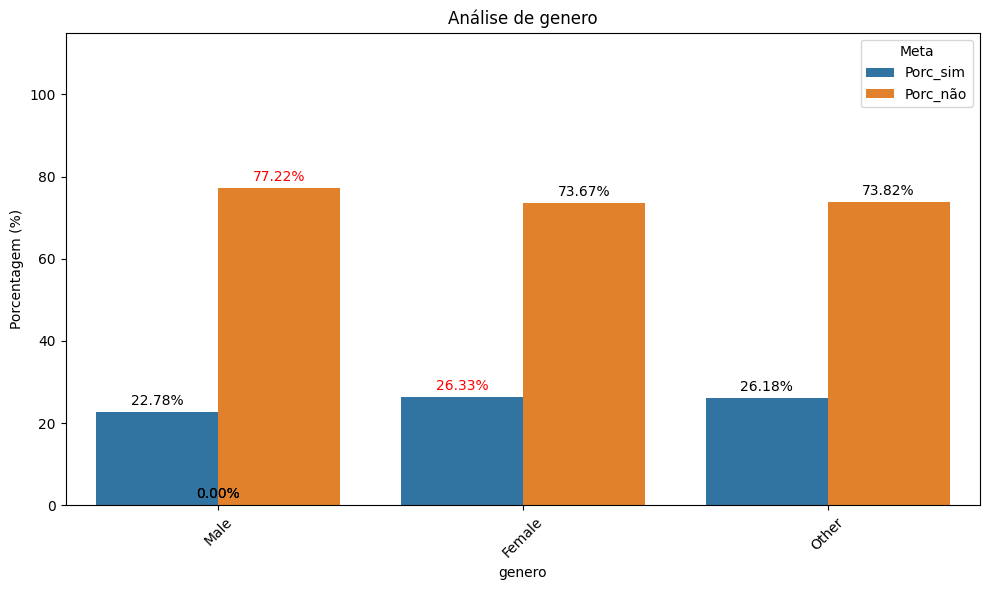

In [72]:
analise_colunas(tabela,'genero')

Análise experiencia_relevante  

,experiencia_relevante,Total,Sim,Porc_sim,Não,Porc_não
0,Has relevent experience,13792,2961,21.47,10831,78.53
1,No relevent experience,5366,1816,33.84,3550,66.16


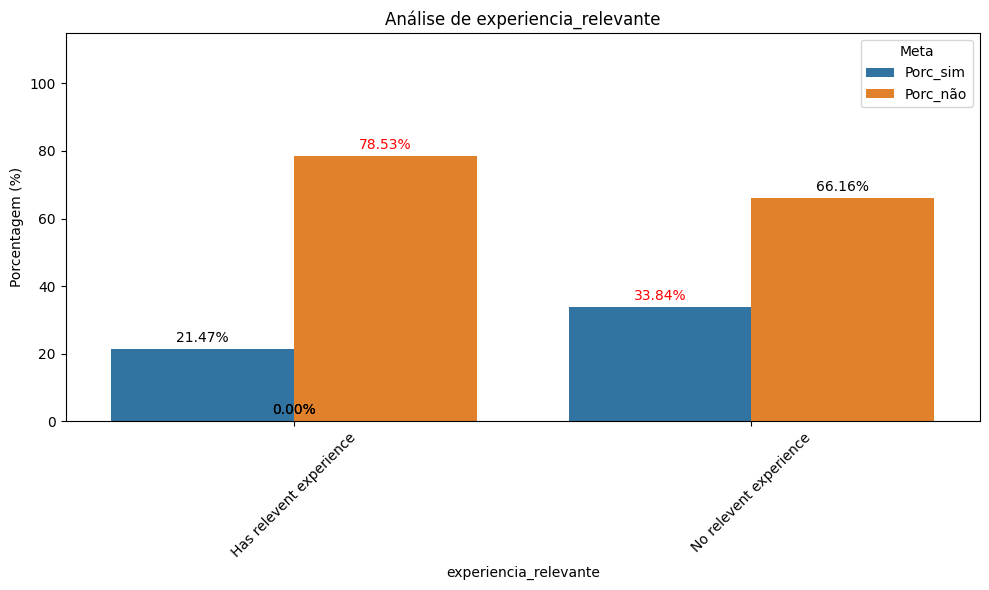

In [73]:
analise_colunas(tabela,'experiencia_relevante')

Análise tipo_curso 
 

,tipo_curso,Total,Sim,Porc_sim,Não,Porc_não
0,no_enrollment,13817,2921,21.14,10896,78.86
1,Full time course,3757,1431,38.09,2326,61.91
2,Part time course,1198,302,25.21,896,74.79


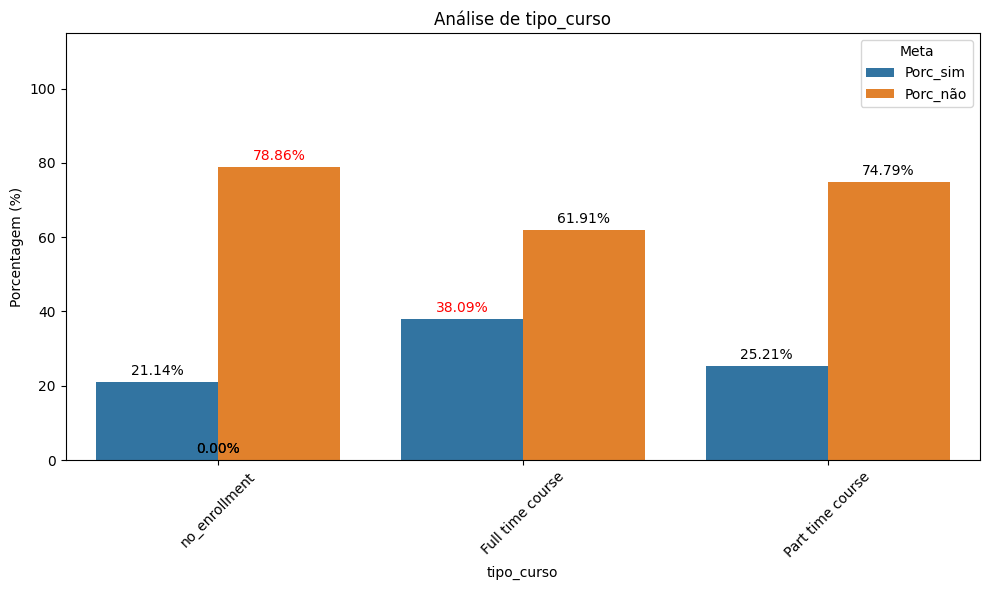

In [74]:
analise_colunas(tabela,'tipo_curso')

Análise nivel_educacao 

,nivel_educacao,Total,Sim,Porc_sim,Não,Porc_não
0,Graduate,11598,3245,27.98,8353,72.02
1,Masters,4361,935,21.44,3426,78.56
2,High School,2017,394,19.53,1623,80.47
3,Phd,414,58,14.01,356,85.99
4,Primary School,308,41,13.31,267,86.69


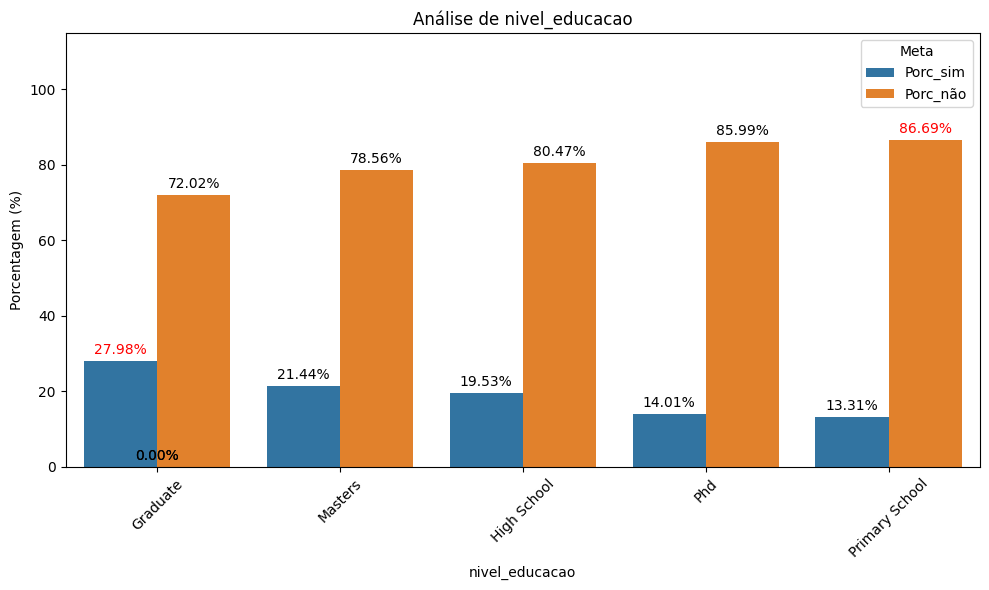

In [75]:
analise_colunas(tabela,'nivel_educacao')

Análise disciplina_principal

,disciplina_principal,Total,Sim,Porc_sim,Não,Porc_não
0,STEM,14492,3791,26.16,10701,73.84
1,Business Degree,327,86,26.30,241,73.70
2,Arts,253,53,20.95,200,79.05
3,Humanities,669,141,21.08,528,78.92
4,No Major,223,55,24.66,168,75.34
5,Other,381,102,26.77,279,73.23


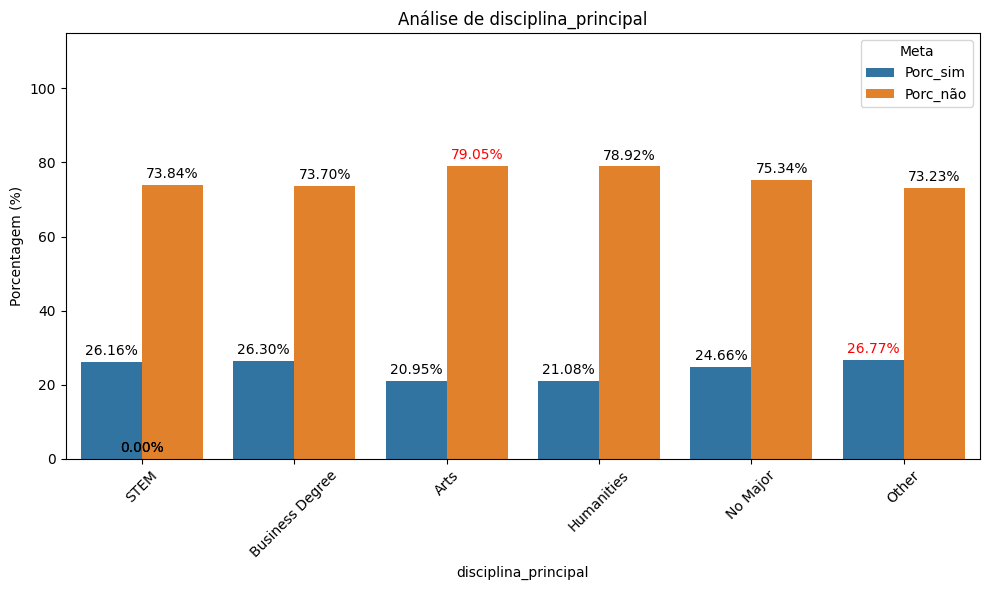

In [76]:
analise_colunas(tabela,'disciplina_principal')

Análise experiencia          

,experiencia,Total,Sim,Porc_sim,Não,Porc_não
0,<1,522.0,237.0,45.40,285.0,54.60
1,1 - 5,5863.0,1954.0,33.33,3909.0,66.67
2,5 - 10,5011.0,1261.0,25.16,3750.0,74.84
3,10 - 15,2829.0,541.0,19.12,2288.0,80.88
4,15 - 20,1582.0,258.0,16.31,1324.0,83.69
5,>20,3286.0,503.0,15.31,2783.0,84.69


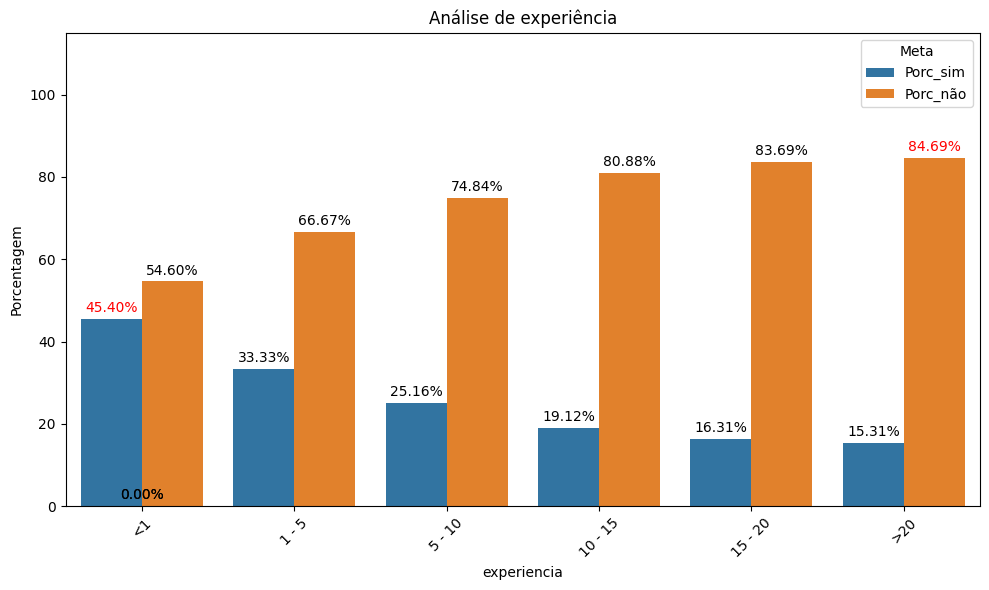

In [77]:
# Definindo os bins (intervalos) e as respectivas categorias
bins = [0, 0.5, 5, 10, 15, 20, 22]
labels = ['<1', '1 - 5', '5 - 10', '10 - 15', '15 - 20', '>20']

# Criando uma nova coluna categorizada
tabela['experiencia'] = pd.cut(tabela['experiencia'], bins=bins, labels=labels)

total_geral = len(tabela)
# Função para agrupar as colunas e calcular contagens e porcentagens
resultado = (tabela.groupby('experiencia', observed=True).apply(lambda x: pd.Series({
            'Total': len(x),
            'Sim': (x['meta'] == 'Sim').sum(),
            'Porc_sim': (round((x['meta'] == 'Sim').mean() * 100, 2)),
            'Não': (x['meta'] == 'Não').sum(),
            'Porc_não': (round((x['meta'] == 'Não').mean() * 100, 2))
        }), include_groups=False)).reset_index()

display(resultado)

pd.set_option('display.max_rows', None)

# Gráfico de barras
plt.figure(figsize=(10, 6))
resultado['Porc_sim'] = resultado['Porc_sim'].astype(float)
resultado['Porc_não'] = resultado['Porc_não'].astype(float)

# Transformando os dados para formato longo
resultado_melted = resultado.melt(id_vars=['experiencia'], value_vars=['Porc_sim', 'Porc_não'], 
                                         var_name='Resposta', value_name='Porcentagem')

# Criando o gráfico de barras
ax = sns.barplot(data=resultado_melted, x='experiencia', y='Porcentagem', hue='Resposta')
plt.title(f'Análise de experiência')
plt.xlabel('experiencia')
plt.ylabel('Porcentagem')
plt.xticks(rotation=45)
plt.ylim(0,115)
plt.legend(title='Meta', loc='best')

# Identificar os dois maiores valores por segmento
top_values = resultado_melted.groupby('Resposta')['Porcentagem'].nlargest(1).reset_index()
top_indices = top_values['level_1'].values

# Adicionando rótulos de dados e destacando os maiores valores
for i, p in enumerate(ax.patches):
    value = p.get_height()
    color = 'red' if i in top_indices else 'black'  # Destacar em vermelho
    ax.annotate(f'{value:.2f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=10, color=color, xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()
plt.show()


Análise tamanho_da_empresa 

,tamanho_da_empresa,Total,Sim,Porc_sim,Não,Porc_não
0,50-99,3083,545,17.68,2538,82.32
1,<10,1308,224,17.13,1084,82.87
2,10000+,2019,385,19.07,1634,80.93
3,5000-9999,563,102,18.12,461,81.88
4,1000-4999,1328,200,15.06,1128,84.94
5,10/49,1471,344,23.39,1127,76.61
6,100-500,2571,415,16.14,2156,83.86
7,500-999,877,152,17.33,725,82.67


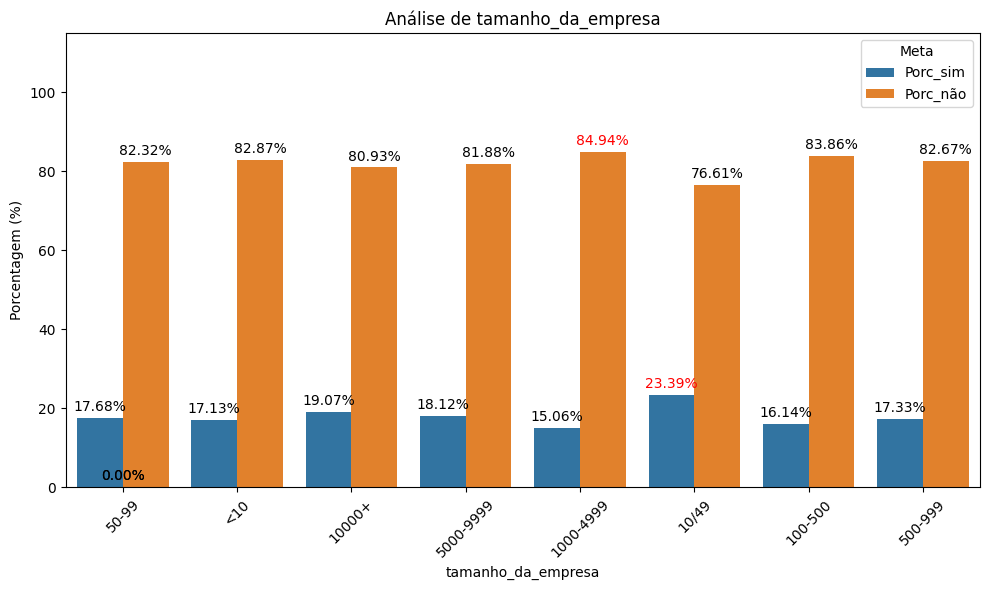

In [78]:
analise_colunas(tabela,'tamanho_da_empresa')

Análise tipo_da_empresa  

,tipo_da_empresa,Total,Sim,Porc_sim,Não,Porc_não
0,Pvt Ltd,9817,1775,18.08,8042,81.92
1,Funded Startup,1001,140,13.99,861,86.01
2,Early Stage Startup,603,142,23.55,461,76.45
3,Other,121,29,23.97,92,76.03
4,Public Sector,955,210,21.99,745,78.01
5,NGO,521,97,18.62,424,81.38


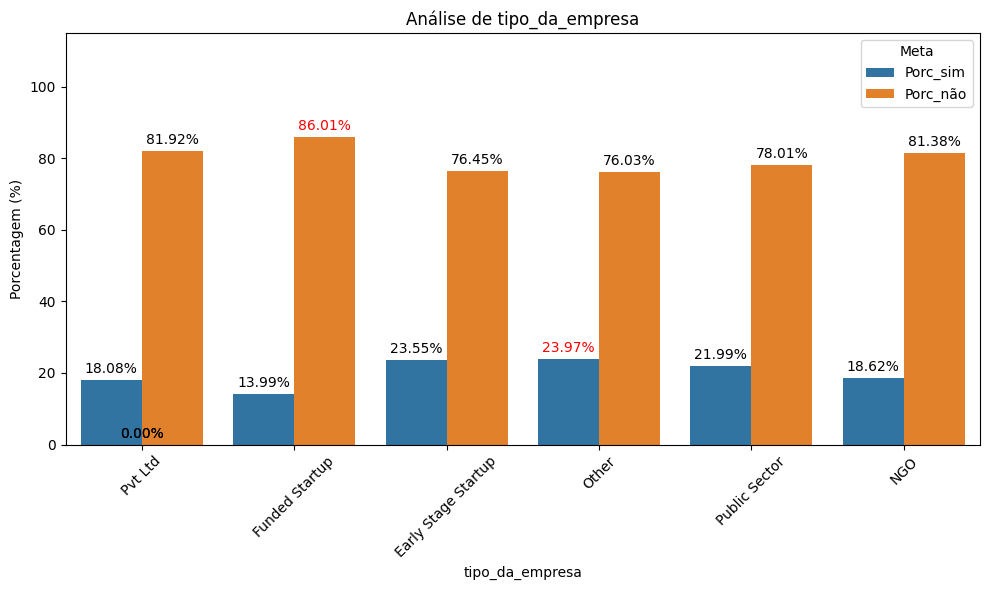

In [79]:
analise_colunas(tabela,'tipo_da_empresa')

Análise tempo_ultimo_emprego  

,tempo_ultimo_emprego,Total,Sim,Porc_sim,Não,Porc_não
0,1,8040,2125,26.43,5915,73.57
1,>4,3290,600,18.24,2690,81.76
2,never,2452,739,30.14,1713,69.86
3,4,1029,228,22.16,801,77.84
4,3,1024,231,22.56,793,77.44
5,2,2900,700,24.14,2200,75.86


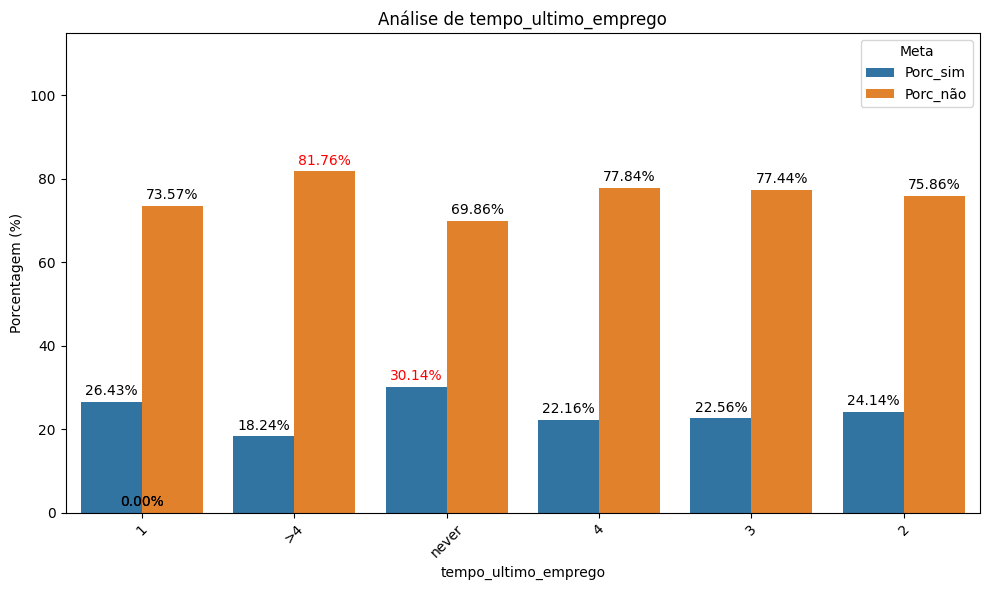

In [80]:
analise_colunas(tabela,'tempo_ultimo_emprego')

Análise tempo_treinamento 

,tempo_treinamento,Total,Sim,Porc_sim,Não,Porc_não
0,0 - 50,10193.0,2604.0,25.55,7589.0,74.45
1,50 - 100,5097.0,1251.0,24.54,3846.0,75.46
2,100 - 150,2089.0,527.0,25.23,1562.0,74.77
3,150 - 200,977.0,234.0,23.95,743.0,76.05
4,200 - 250,390.0,74.0,18.97,316.0,81.03
5,250 - 300,214.0,49.0,22.90,165.0,77.10
6,300 - 350,198.0,38.0,19.19,160.0,80.81


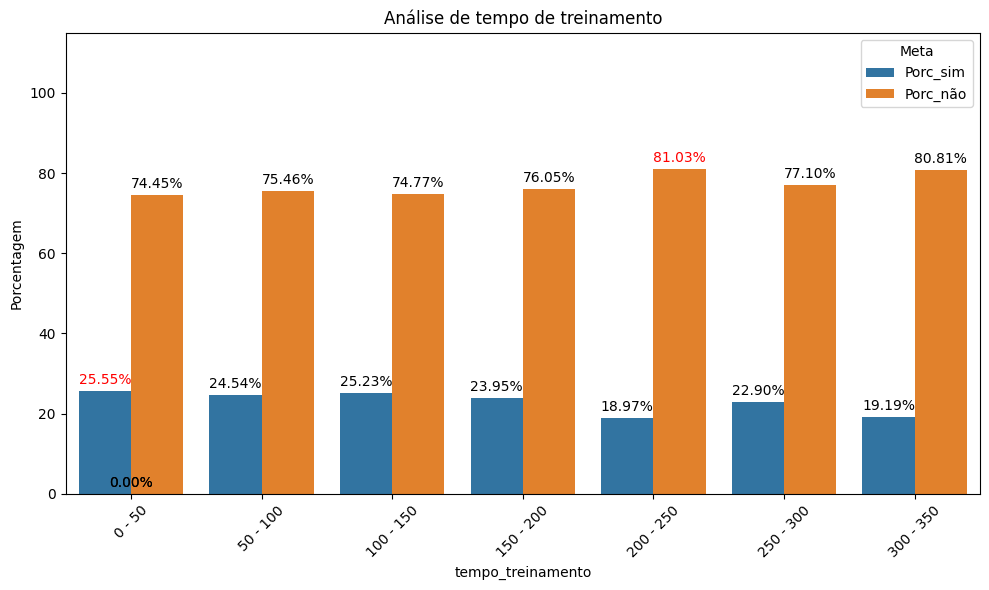

In [81]:
# Definindo os bins (intervalos) e as respectivas categorias
bins = [0, 50, 100, 150, 200, 250, 300, 350]
labels = ['0 - 50', '50 - 100', '100 - 150', '150 - 200', '200 - 250', '250 - 300', '300 - 350']

# Criando uma nova coluna categorizada
tabela['tempo_treinamento'] = pd.cut(tabela['tempo_treinamento'], bins=bins, labels=labels)
total_geral = len(tabela)

# Função para agrupar as colunas e calcular contagens e porcentagens
resultado = (tabela.groupby('tempo_treinamento',observed=True).apply(lambda x: pd.Series({
            'Total': len(x),
            'Sim': (x['meta'] == 'Sim').sum(),
            'Porc_sim': (round((x['meta'] == 'Sim').mean() * 100, 2)),
            'Não': (x['meta'] == 'Não').sum(),
            'Porc_não': (round((x['meta'] == 'Não').mean() * 100, 2))
        }),include_groups=False)).reset_index()
   
display(resultado)

pd.set_option('display.max_rows', None)
# Gráfico de barras
plt.figure(figsize=(10, 6))
resultado['Porc_sim'] = resultado['Porc_sim'].astype(float)
resultado['Porc_não'] = resultado['Porc_não'].astype(float)

# Transformando os dados para formato longo
resultado_melted = resultado.melt(id_vars=['tempo_treinamento'], value_vars=['Porc_sim', 'Porc_não'], 
                                         var_name='Resposta', value_name='Porcentagem')

# Criando o gráfico de barras
ax = sns.barplot(data=resultado_melted, x='tempo_treinamento', y='Porcentagem', hue='Resposta')
plt.title(f'Análise de tempo de treinamento')
plt.xlabel('tempo_treinamento')
plt.ylabel('Porcentagem')
plt.xticks(rotation=45)
plt.ylim(0,115)
plt.legend(title='Meta', loc='best')

# Identificar os dois maiores valores por segmento
top_values = resultado_melted.groupby('Resposta')['Porcentagem'].nlargest(1).reset_index()
top_indices = top_values['level_1'].values

# Adicionando rótulos de dados e destacando os maiores valores
for i, p in enumerate(ax.patches):
    value = p.get_height()
    color = 'red' if i in top_indices else 'black'  # Destacar em vermelho
    ax.annotate(f'{value:.2f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=10, color=color, xytext=(0, 5),
                textcoords='offset points')


plt.tight_layout()
plt.show()

Machine Learning

In [919]:
# Transformando as colunas não numéricas em dummies
tabela_dummie = pd.get_dummies(tabela_2, columns=[ 'genero',	
                                         'experiencia_relevante',	
                                         'tipo_curso',	
                                         'nivel_educacao',	
                                         'disciplina_principal',
                                         'experiencia',	
                                         'tamanho_da_empresa',	
                                         'tipo_da_empresa',	
                                         'tempo_ultimo_emprego'])

tabela_teste_dummie = pd.get_dummies(tabela_teste_2, columns=[	
                                         'genero',	
                                         'experiencia_relevante',	
                                         'tipo_curso',	
                                         'nivel_educacao',	
                                         'disciplina_principal',
                                         'experiencia',	
                                         'tamanho_da_empresa',	
                                         'tipo_da_empresa',	
                                         'tempo_ultimo_emprego'])

tabela_dummie = tabela_dummie.drop(columns='cidade')
tabela_teste_dummie = tabela_teste_dummie.drop(columns='cidade')

# Carregar os dados
train_data = tabela_dummie
test_data = tabela_teste_dummie

# Separar features e target no conjunto de treino
X_train = train_data.drop(columns=['meta'])
y_train = train_data['meta']

# Separar features no conjunto de teste
X_test = test_data.drop(columns=['meta'], errors='ignore')
y_test = test_data['meta'] if 'meta' in test_data.columns else None

# Criar o modelo
model = RandomForestRegressor(random_state=42)

# Otimizar hiperparâmetros com GridSearchCV
param_grid = {
    'n_estimators': [200, 500],
    'max_depth': [5 ,10],
    'min_samples_split': [5, 8],
    'min_samples_leaf': [2, 5]
}

grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, error_score='raise')
grid_search.fit(X_train, y_train)

# Melhor modelo
gbest_model = grid_search.best_estimator_
print("Melhores parâmetros:", grid_search.best_params_)

# Fazer previsões
y_pred_train = gbest_model.predict(X_train)
y_pred_test = gbest_model.predict(X_test)

# Avaliar o modelo
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
train_mae = mean_absolute_error(y_train, y_pred_train)

print(f"RMSE (Treino): {train_rmse:.2f}")
print(f"MAE (Treino): {train_mae:.2f}")

if y_test is not None:
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_mae = mean_absolute_error(y_test, y_pred_test)
    r2 = r2_score(y_test, y_pred_test)

    print(f"RMSE (Teste): {test_rmse:.2f}")
    print(f"MAE (Teste): {test_mae:.2f}")
    print(f"R² (Teste): {r2:.2f}")

# Inserir os resultados no conjunto de teste
tabela_teste = tabela_teste
X_test_results = X_test.copy()
X_test_results['Predicted'] = y_pred_test

if y_test is not None:
    X_test_results['Actual'] = y_test

tabela_teste['meta'] = X_test_results['Predicted'].round(0)

tabela_teste.to_csv('tabela_teste.csv', index=False)

Melhores parâmetros: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 500}
RMSE (Treino): 0.35
MAE (Treino): 0.27
